#### Torch CNN - CIFAR10

In [1]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

BATCH_SIZE = 128
DOWNLOAD = False
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f"Using a subset of {SUBSET} samples for training and testing.")
else:
    train_set, test_set = train_dataset, test_dataset
    print("Using the full dataset for training and testing.")

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Using the full dataset for training and testing.
cuda


In [2]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step,
    }
    with open(f'{save_path}/SGD_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)
    

In [3]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval() 
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    with torch.no_grad(): 
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [4]:
from models import SimpleCNN
from optim.sgd_sngl import OneStepSGD
from optim.sgd_mult import ManyStepSGD
import time 

def modeling(n_step=2, n_epochs=15, lr=0.133, momentum=0, threshold=90):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()

    if n_step == 1:
        optimizer = OneStepSGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer = ManyStepSGD(model.parameters(), lr=lr, momentum=momentum, n_step=n_step)

    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []

    for i, epoch in enumerate(range(n_epochs)):
#         print(f"Epoch: {i+1}/{n_epochs}")
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        run_time = time.time() - _start

        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)
        
        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {run_time}')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train acc {epoch_train_acc:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

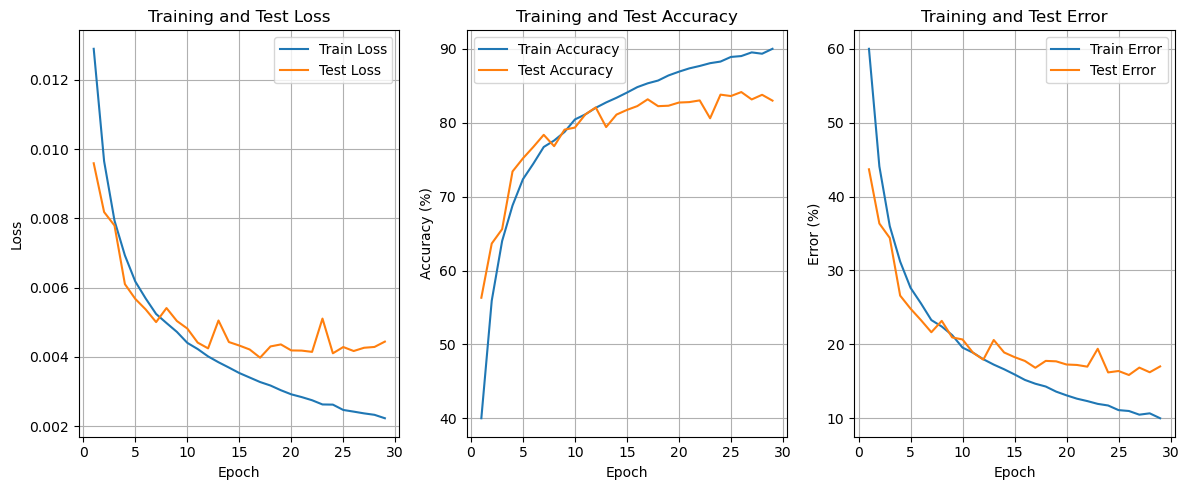

In [6]:
from plot import metrics_plot
n_epochs = 50
n_step = 1
lr = 0.133
threshold = 90
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                   n_epochs=n_epochs, 
                                                                                   lr=lr,
                                                                                   threshold=threshold,
                                                                                  )
save_path = 'scores/epoch_scores'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=n_step,
                 )
actual_nepochs = len(train_losses)
metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

E [1/29]. train_loss_acc: 2.1350, 20.46%, test_acc: 27.66%, run_time: 7.606013774871826
E [2/29]. train_loss_acc: 1.7219, 37.02%, test_acc: 45.72%, run_time: 7.61558985710144
E [3/29]. train_loss_acc: 1.4688, 46.78%, test_acc: 53.49%, run_time: 7.6161580085754395
E [4/29]. train_loss_acc: 1.2813, 53.84%, test_acc: 60.01%, run_time: 7.636431932449341
E [5/29]. train_loss_acc: 1.1241, 60.24%, test_acc: 65.31%, run_time: 7.621943235397339
E [6/29]. train_loss_acc: 1.0273, 63.70%, test_acc: 63.64%, run_time: 7.618381500244141
E [7/29]. train_loss_acc: 0.9401, 67.08%, test_acc: 70.01%, run_time: 7.625479221343994
E [8/29]. train_loss_acc: 0.8806, 69.20%, test_acc: 71.39%, run_time: 7.605658292770386
E [9/29]. train_loss_acc: 0.8394, 70.63%, test_acc: 73.48%, run_time: 7.623720645904541
E [10/29]. train_loss_acc: 0.8042, 71.95%, test_acc: 70.51%, run_time: 7.614414930343628
E [11/29]. train_loss_acc: 0.7695, 73.16%, test_acc: 73.18%, run_time: 7.605987071990967
E [12/29]. train_loss_acc: 0.7

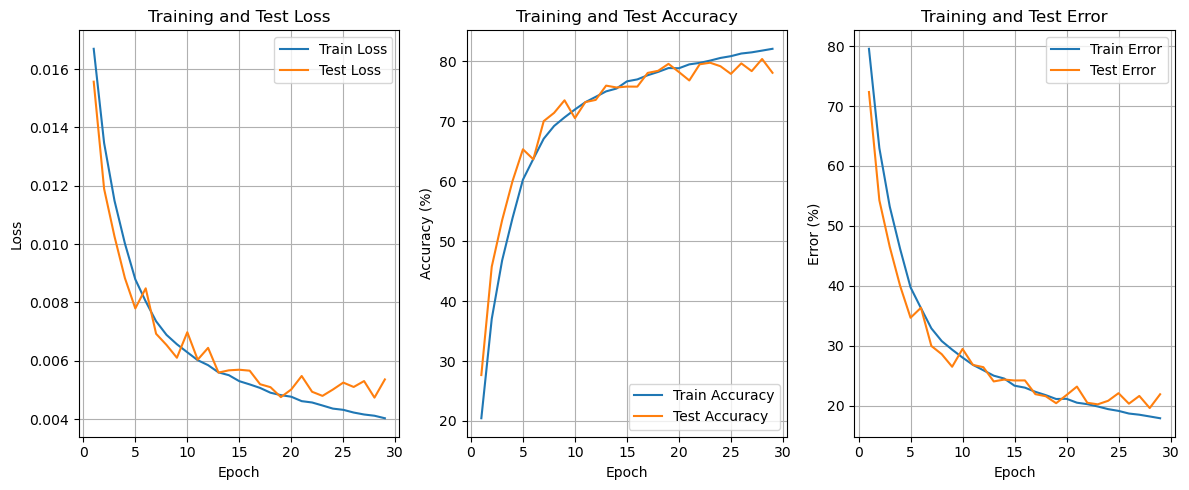

In [7]:
from plot import metrics_plot
n_epochs = 29
n_step = 3
lr = 0.133
threshold = 90
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                   n_epochs=n_epochs, 
                                                                                   lr=lr,
                                                                                   threshold=threshold,
                                                                                  )
save_path = 'scores/epoch_scores'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=n_step,
                 )
actual_nepochs = len(train_losses)
metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

E [1/29]. train_loss_acc: 2.3400, 9.94%, test_acc: 10.00%, run_time: 7.6785643100738525
E [2/29]. train_loss_acc: 2.3038, 10.06%, test_acc: 10.00%, run_time: 7.661321401596069
E [3/29]. train_loss_acc: 2.3040, 9.70%, test_acc: 10.00%, run_time: 7.646243572235107
E [4/29]. train_loss_acc: 2.3041, 9.66%, test_acc: 10.00%, run_time: 7.651582956314087
E [5/29]. train_loss_acc: 2.3038, 9.76%, test_acc: 10.00%, run_time: 7.6395392417907715
E [6/29]. train_loss_acc: 2.3039, 10.07%, test_acc: 10.00%, run_time: 7.647194862365723
E [7/29]. train_loss_acc: 2.3040, 10.14%, test_acc: 10.00%, run_time: 7.647233724594116
E [8/29]. train_loss_acc: 2.3037, 10.02%, test_acc: 10.00%, run_time: 7.643139839172363
E [9/29]. train_loss_acc: 2.3036, 10.22%, test_acc: 10.00%, run_time: 7.645925521850586
E [10/29]. train_loss_acc: 2.3037, 10.03%, test_acc: 10.00%, run_time: 7.658559560775757
E [11/29]. train_loss_acc: 2.3041, 9.91%, test_acc: 10.00%, run_time: 7.647937774658203
E [12/29]. train_loss_acc: 2.3038

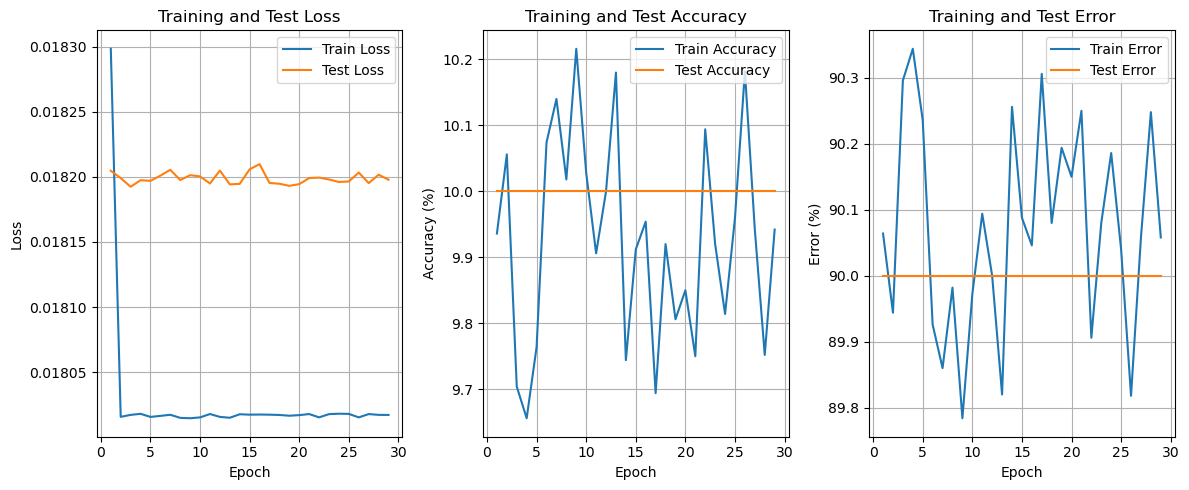

In [8]:
from plot import metrics_plot
n_epochs = 29
n_step = 5
lr = 0.133
threshold = 90
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                   n_epochs=n_epochs, 
                                                                                   lr=lr,
                                                                                   threshold=threshold,
                                                                                  )
save_path = 'scores/epoch_scores'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=n_step,
                 )
actual_nepochs = len(train_losses)
metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)